# Explanation pipeline

![pipeline](pipeline2.png)

In [1]:
# Reload modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

# Import from code root directory
import sys; sys.path.insert(0, '../')

# Imports
from collections import OrderedDict
from access.amazon_doc2vec_reader import AmazonDoctovecReader
from access.amore_doc2vec_reader import AmoreDoctovecReader
from access.amore_bert_reader import AmoreBertReader
from access.amore_reader import AmoreReader
from detection.bounding_boxes import BoundingBoxes
from explanations.count_explainer import CountExplainer
from explanations.tfidf_explainer import TfidfExplainer
from explanations.wordcloud import Wordcloud
from explorer.search import Search

In [2]:
# Configuration
# Amazon text and embeddings directory
data_directory_amazon = '/home/eml4u/EML4U/data/amazon-complete'
# AMORE benchmark directory
data_directory_amore = '/home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/'
# AMORE benchmark ID
amore_benchmark_id = '1'

## Data Readers

- Implementations of `ReaderInterface`.
- Creates `reader` instance.

In [3]:
# Amazon test 1
# 10,000 1-star items from 2007
# 10,000 5-star items from 2007
if False:
    reader = AmazonDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['distributions_file'] = '/tmp/amore_test_1.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [4]:
# Amazon test 2
# 2011: 25K positive and 25K negative
# 2012: 40K positive and 10K negative
if False:
    reader = AmazonDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['distributions_file'] = '/tmp/amore_test_2.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [5]:
# AMORE Benchmark doc2vec reader
if False:
    reader = AmoreDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['amore_directory']    = data_directory_amore
    options['amore_benchmark_id'] = amore_benchmark_id
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [6]:
# AMORE Benchmark BERT reader
if True:
    reader = AmoreBertReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['amore_directory']    = data_directory_amore
    options['amore_benchmark_id'] = amore_benchmark_id
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

AMORE directory:                    /home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/
AMORE benchmark ID:                 1
AmoreDoctovecReader data directory: /home/eml4u/EML4U/data/amazon-complete


## Distribution information

In [7]:
distribution_a_id = reader.get_distribution_ids()[0]
distribution_b_id = reader.get_distribution_ids()[1]

print('Distribution IDs:', distribution_a_id, distribution_b_id)
print('Size', str(distribution_a_id) + ':', len(reader.get_item_ids(distribution_a_id)))
print('Size', str(distribution_b_id) + ':', len(reader.get_item_ids(distribution_b_id)))
print('Dimensions:', reader.get_dimensions())

Distribution IDs: 0 1
Size 0: 10000
Size 1: 10000
Dimensions: 768


## Drift Detectors

Implementations of `DetectionInterface`.

In [8]:
# Gets outliers based on boundaries derived from single dimension values.
detector = BoundingBoxes()
detector.initialize({
    'percentile':          0.995,
    'enclosed_dimensions': reader.get_dimensions()
})
detector.set_reader(reader)

BoundingBoxes percentile:                            0.995
BoundingBoxes minimum number of enclosed dimensions: 768


In [9]:
# Detect drift and save results in drift_results
drift_results = OrderedDict()
drift_results[distribution_a_id] = detector.select_item_ids(distribution_a_id, distribution_b_id)
drift_results[distribution_b_id] = detector.select_item_ids(distribution_b_id, distribution_a_id)
print('Drift result IDs:', drift_results.keys())
print('Drift result numbers of items ' + str(distribution_a_id) + ':', len(drift_results[distribution_a_id]), '/', len(reader.get_item_ids(distribution_a_id)), end='')
print(' (' + str(round(100*len(drift_results[distribution_a_id])/len(reader.get_item_ids(distribution_a_id)), 2)), '%)')
if False:
    print('Drift result numbers of items ' + str(distribution_b_id) + ':', len(drift_results[distribution_b_id]), '/', len(reader.get_item_ids(distribution_b_id)), end='')
    print(' (' + str(round(100*len(drift_results[distribution_b_id])/len(reader.get_item_ids(distribution_b_id)), 2)), '%)')

BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
Drift result IDs: odict_keys([0, 1])
Drift result numbers of items 0: 816 / 10000 (8.16 %)


In [10]:
# Loads perfect results
if False:
    #dataset_id = '1'
    dataset_id = '2'
    amore_reader = AmoreReader(data_directory=data_directory_amore)
    drift_results[distribution_a_id] = amore_reader.get_drift_ids(dataset_id, subset=None)
    print('Size of perfect results:', len(drift_results[distribution_a_id]))
    print('Token base of perfect results:', amore_reader.get_drift_tokens(dataset_id, subset=None))
    del data_directory
    del dataset_id

## Drift Explainers

Note: TF-IDF values of tokens in single detected documents are just summed up in the current version.

In [11]:
if True:
    explainer = TfidfExplainer()
    explainer.initialize({'max_results':50})

TfidfExplainer max_results: 50


In [12]:
if False:
    explainer = CountExplainer()
    explainer.initialize({'max_results':50})

In [13]:
token_dict_a = explainer.get_token_dict(drift_results[distribution_a_id], drift_results[distribution_b_id], reader)
print(token_dict_a)

AmazonPickleReader: Reading raw data
{'great': 0.00021268275814123662, 'love': 0.00016145803851137292, 'best': 0.0001345288062865821, 'japanese': 0.0001131694770587282, 'excellent': 0.00011244206870896912, 'predator': 0.00010160304758299158, 'books': 9.564477093949532e-05, 'craven': 8.928131133018318e-05, 'seagal': 8.344218710835642e-05, 'remake': 8.343675535616468e-05, 'shyamalan': 8.031335726675711e-05, 'slater': 7.403351296082658e-05, 'husband': 7.214570860092752e-05, 'joke': 7.082912898475225e-05, 'troll': 6.677957554576451e-05, 'violence': 6.50989081477456e-05, 'hbo': 6.368950911678778e-05, 'home': 6.197713011845383e-05, 'blade': 5.864985437509664e-05, 'horror': 5.7705530274013085e-05, '2005': 5.65025258859771e-05, 'pixar': 5.641963202976226e-05, 'creature': 5.5814289265189e-05, 'reid': 5.580242852073202e-05, 'wes': 5.5620666106231363e-05, 'boll': 5.555283022201793e-05, 'zombie': 5.475853323241839e-05, 'bewitched': 5.4625293628461185e-05, 'hurt': 5.438904158967928e-05, 'sentence':

In [14]:
if False:
    token_dict_b = explainer.get_token_dict(drift_results[distribution_b_id], drift_results[distribution_a_id], reader)
    print(token_dict_b)

### Verify

In [15]:
amore_reader = AmoreReader(data_directory=data_directory_amore)
drift_ids = amore_reader.get_drift_ids(amore_benchmark_id, subset=None)
print('drift_ids', len(drift_ids))
detected_ids = drift_results[distribution_a_id]
print('detected_ids', len(detected_ids))
tp = list(set(drift_ids).intersection(drift_results[distribution_a_id]))
print('tp', len(tp))
#fp = detected_ids - drift_ids
fp = [i for i in detected_ids if i not in drift_ids]
print('fp', len(fp))

#tn = 
# non-drift-ids = distribution_b_id
# note: maybe only the tp should count. correct drift docs can not be determined 100%, i think.

drift_ids 1000
detected_ids 816
tp 47
fp 769


In [16]:
drift_tokens = amore_reader.get_drift_tokens(amore_benchmark_id, subset=None)
print('drift_tokens', drift_tokens)
top_computed_tokens = list(token_dict_a.keys())[:len(drift_tokens)]
print('top_computed_tokens', top_computed_tokens)

# note: how many tokens would be best to compare?

drift_tokens ['excellent', 'best', 'great', 'love']
top_computed_tokens ['great', 'love', 'best', 'japanese']


### Visual representations

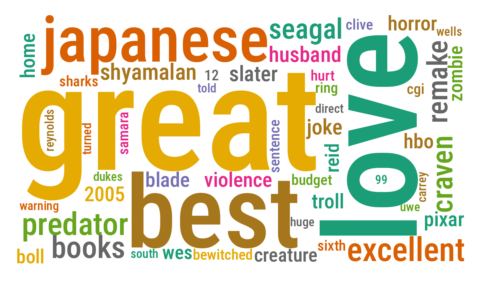

In [17]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_a))

In [18]:
if False:
    wordcloud = Wordcloud()
    wordcloud.plot(wordcloud.get_wordcloud(token_dict_b))

## Explorer

In [19]:
search = Search()
search.initialize({'reader':reader})

In [20]:
query = 'season'

In [21]:
search_results_a = search.search(query, item_ids=drift_results[distribution_a_id], max=-1)

Searched in 816 items
Found 10 items (1.23 %)


In [22]:
search_results_b = search.search(query, item_ids=drift_results[distribution_b_id], max=-1)

Searched in 1069 items
Found 14 items (1.31 %)


In [23]:
# Print item IDs and texts
#search.print_results(search_results_a, max=10)

In [24]:
# Print item IDs and texts
#search.print_results(search_results_b, max=10)